# Generative Adversarial Networks

[Generative Adversarial Networks (GANs)](https://arxiv.org/pdf/1406.2661) are a class of machine learning models introduced by Ian Goodfellow and colleagues in 2014. A GAN consists of two neural networks, trained simultaneously in a competitive setting often described as a two-player minimax game:

- **Generator $G$**: Learns to map random noise (typically sampled from a simple distribution like a standard normal) into data samples that resemble the training data. Its goal is to produce outputs that look “real.”

- **Discriminator $D$**: Learns to distinguish between real data (from the true distribution) and fake data (produced by the generator). Its goal is to correctly classify inputs as either real or generated.

The interaction between $G$ and $D$ can be likened to counterfeiters versus the police: counterfeiters (the generator) produce increasingly realistic fake currency, while the police (the discriminator) improve their ability to detect counterfeits. This adversarial process continues until the generated samples become indistinguishable from real data.

## Training Objective

The training process involves alternating updates to D and G:

1. **Sampling:** Draw real data samples $x \sim \mathbb{P}_{d}$ and random noise $z \sim \mathbb{P}_z$ (e.g., $N(0, I)$)
2. **Generation:** Transform $z$ through the generator to produce $\hat{x} = G(z)$.
3. **Discrimination:** Feed both $x$ and $\hat{x}$ into the discriminator, which outputs a scalar score representing the probability that the input is real.
4. **Optimization:** 
    - The discriminator is trained to maximize the probability of correctly classifying real versus generated samples.
    - The generator is trained to maximize the discriminator’s misclassification of generated samples as real.

The minimax objective is:

```math
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim \mathbb{P}_{d}}[\log D(x)] + \mathbb{E}_{z \sim \mathbb{P}_{z}}[\log (1 - D(G(z)))]
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import torchvision
import os
import gzip
import tarfile
import gc
from datetime import datetime
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
print(torch.__version__)

1.13.1+cu117


## Dataset

This project implements GAN models trained on the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which contains over 200K images of celebrity faces. The images are transformed to be 128 $\times$ 128 in dimension. Below are some examples of the images in the dataset.

In [2]:
import PIL.Image

def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions

In [3]:
class CelebaDataset(Dataset):
    def __init__(self, root, size=128, train=True):
        super(CelebaDataset, self).__init__()
        self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root), transform=transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
    def __getitem__(self,index):
        img = self.dataset_folder[index]
        return img[0]

    def __len__(self):
        return len(self.dataset_folder)

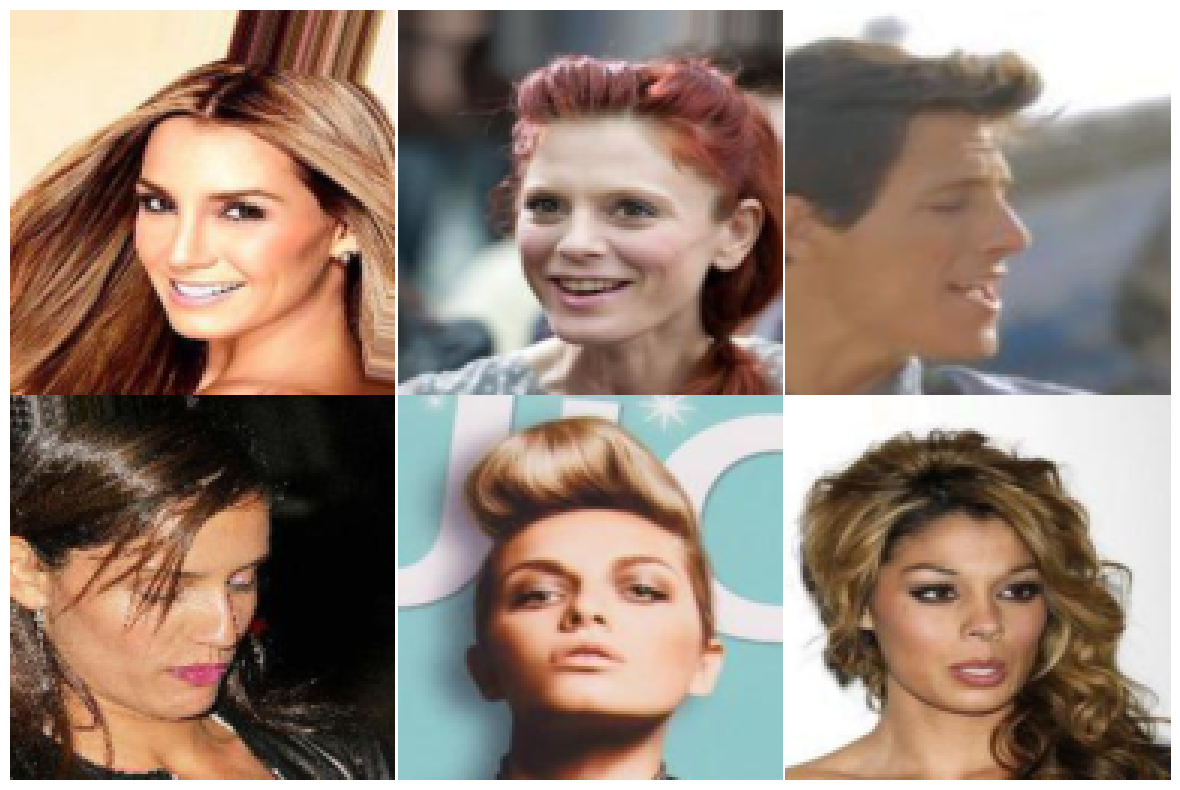

In [4]:
def plot_samples(data):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    for i,a in enumerate(ax.flatten()):
        img = data[i]
        img = np.dstack([img[0], img[1], img[2]])
        a.axis('off')
        a.imshow(img)
        a.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def plot_random_samples(data, n=20):
    samples = np.random.choice(len(data), n, replace=False)
    w = 5
    h = int(np.ceil(n/w))
    fig, ax = plt.subplots(h, w, figsize=(20, 16))
    for a,s in zip(ax.flatten(),samples):
        img = data[s]
        img = np.dstack([img[0], img[1], img[2]])
        a.axis('off')
        a.imshow(img)
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def plot_image(img):
    img = np.dstack([img[0], img[1], img[2]])
    fig = plt.figure()
    plt.axis('off')
    plt.imshow(img)
    plt.show()

celeba_dataset = CelebaDataset("data")

plot_samples(celeba_dataset)

## Generator Model Architecture

![DCGAN Generator Architecture](graphics/DCGAN.PNG)

The generator model follows the [DCGAN](https://arxiv.org/pdf/1511.06434) (Deep Convolutional GAN) architecture, which consists of repeated upsampling and convolutional layer with ReLU activation. This model takes in vectors $z \in \mathbb{R}^{128}$ and outputs 128 $\times$ 128 $\times$ 3 pixel color images.

In [73]:
z_dim = 64
class Generator(nn.Module):
    def __init__(self, input_size=z_dim):
        super(Generator, self).__init__()
        # Project and reshape
        self.linear = nn.Linear(input_size, 1024*4*4)
        # Convolution1: (1024,4,4) -> (512,8,8)
        F = 1024
        N = 5
        self.upsample = nn.ModuleList(\
            nn.Upsample(scale_factor=2, 
            mode="nearest")
            for i in range(N)
        )
        #self.pad = nn.ReflectionPad2d(1)
        self.convs = nn.ModuleList(nn.Conv2d(F//(2**i), 
                                             F//(2**(i+1)), 
                                             3, stride=1, padding=1) 
                                   for i in range(N))
        self.bn = nn.ModuleList(nn.BatchNorm2d(F//(2**i)) for i in range(1, N+1))
        
        self.conv_out = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        
        h, w = x.shape
        x = self.linear(x)
        x = x.reshape(h, 1024, 4, 4)
        
        for i in range(5):
            x = self.upsample[i](x)
            #x = self.pad(x)
            x = self.relu(self.convs[i](x))
            x = self.bn[i](x)
        #x = self.pad(x)
        x = self.sig(self.conv_out(x))
        return x

### Samples of images generated by an untrained generator

torch.Size([32, 3, 128, 128])


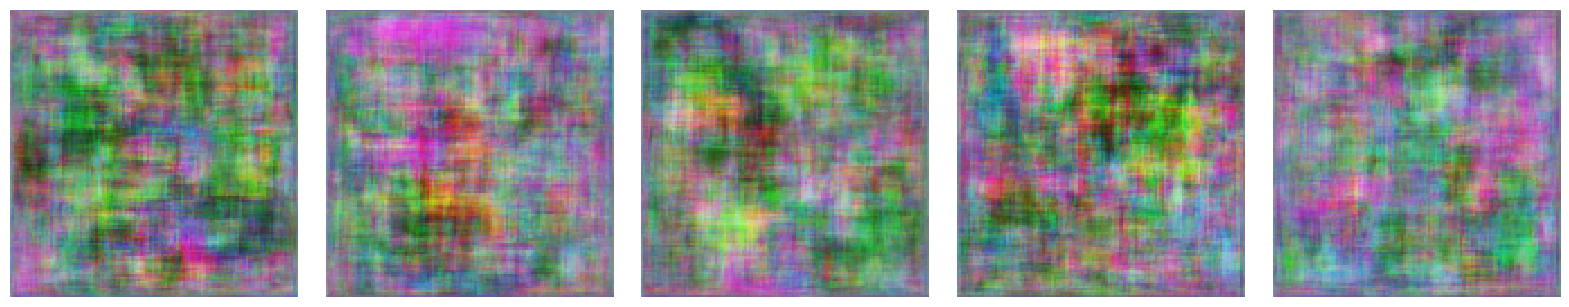

In [9]:
gc.collect()
batch_size = 32
G = Generator(input_size=z_dim)
z = torch.randn(batch_size, z_dim)
x = G(z)
print(x.shape)
plot_random_samples(x.detach().numpy(), n=5)

## Discriminator Architecture

The discriminator model is essentially the opposite of the generator, consisting of repeated convolutional downsampling. It takes as inputs a 128 $\times$ 128 $\times$ 3 color images and outputs a scalar-valued score that represent how likely the image comes from the real dataset rather than being produced by the generator.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        F = 64
        N = 4
        
        self.conv_in = nn.Conv2d(3, F, kernel_size=3, stride=1, padding=1)

        self.dsample_list = nn.ModuleList(nn.Conv2d(F*2**i, F*2**i, 2, stride=2) 
                                          for i in range(N))
        self.bn_list = nn.ModuleList(nn.BatchNorm2d(F*2**i) for i in range(N))
        self.conv_list = nn.ModuleList(nn.Conv2d(F*2**i, F*2**(i+1), 3, stride=1, padding=1) 
                                       for i in range(N))

        
        self.dsample_out = nn.Conv2d(F*2**N, 1, 2, stride=2)
        self.fc = nn.Linear(4**(6-N), 1)
        self.N = N
        self.relu = nn.ReLU()
        self.leaky = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        b,_,_,_ = x.shape
        x = self.relu(self.conv_in(x))
        for i in range(self.N):
            x = self.dsample_list[i](self.leaky(x))
            x = self.bn_list[i](x)
            x = self.conv_list[i](x)
        x = self.dsample_out(self.leaky(x))
        x = x.reshape(b, -1)
        x = self.fc(x)
        return x
    

In [63]:
G = Generator(input_size=z_dim)
z = torch.randn(batch_size, z_dim)
x = G(z)
D = Discriminator()
D(x).shape

torch.Size([64, 1])

## Training and Optimization

In the original GAN formulation, the discriminator outputs a probability indicating how likely a sample is to come from the real data distribution. The **Wasserstein GAN (WGAN)** redefines this quantity and instead optimizes the following objective:

```math
\min_G \max_D \mathbb{E}_{x \sim \mathbb{P}_{d}}[D(x)] - \mathbb{E}_{z \sim \mathbb{P}_{z}}[D(G(z))]
```
This formulation is derived from the **Kantorovich–Rubinstein duality**, which requires the discriminator $D$ (often called the critic in WGANs) to be a 1-Lipschitz function. In practice, we enforce this constraint by following the approach of [Gulrajani et al. (2017)](https://arxiv.org/pdf/1704.00028), which introduces a gradient penalty term:
```math
\lambda (||\nabla_{\hat{x}} D_w(\hat{x})||_2 - 1)^2
```

This penalty encourages the gradient norm of the critic with respect to its input $\hat{x}$ to remain close to 1, thereby ensuring the Lipschitz condition holds and stabilizing training.

The full training algorithm follows the pseudocode below:

<div style="border: 2px solid #000000; font-family: Computer Modern Roman; padding: 10px; background: #000000; display: inline-block; max-width: fit-content;">

---

**Algorithm 1** WGAN with graident penalty.

---

**Require:** The gradient penalty coefficeint $\lambda$, the number of critic iterations per generator iteration \
$n_{\text{critic}}$, the batch size $m$, Adam hyperparameters $\alpha$, $\beta_1$, $\beta_2$.\
**Require:** initial critic parameters $w_0$, initial generator parameters $\theta_0$.\
&nbsp;&nbsp;1: &nbsp;**while** $\theta$ has not converged **do**\
&nbsp;&nbsp;2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for** $t = 1,...,n_{\text{critic}}$ **do**\
&nbsp;&nbsp;3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for** $i = 1,...,m$ **do**\
&nbsp;&nbsp;4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample real data $x \sim \mathbb{P}_d$, latent variable $z \sim \mathbb{P}_z$, a random number $\epsilon \sim U[0, 1]$.\
&nbsp;&nbsp;5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\tilde{x} \leftarrow G_{\theta}(z)$\
&nbsp;&nbsp;6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\hat{x} \leftarrow \epsilon x + (1 - \epsilon) \tilde{x}$\
&nbsp;&nbsp;7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$L^{(i)} \leftarrow D_w(\tilde(x)) - D_w(s) + \lambda (||\nabla_{\hat{x}} D_w(\hat{x})||_2 - 1)^2$\
&nbsp;&nbsp;8: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**end for**\
&nbsp;&nbsp;9: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w \leftarrow \text{Adam}(\nabla_w \frac{1}{m}\sum^m_{i=1} L^{(i)}, w, \alpha, \beta_1, \beta_2)$\
&nbsp;&nbsp;2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Sample a batch of latent variables $\{z^{(i)}\}^m_{i=1} \sim \mathbb{P}_z$.\
&nbsp;&nbsp;1: &nbsp;**end while**

---

</div>


In [64]:
class WGAN_gloss(nn.Module):
    def __init__(self):
        super(WGAN_gloss, self).__init__()

    def forward(self, G, D, z):
        return -D(G(z))

class WGAN_dloss(nn.Module):
    def __init__(self):
        super(WGAN_dloss, self).__init__()

    def forward(self, G, D, x, z, eps, lmda):
        y = G(z)
        x_hat = eps*x + (1-eps)*y
        x_hat.requires_grad = True
        confidence = D(x_hat).mean()
        grad = torch.autograd.grad(confidence, x_hat, create_graph=True)[0]
        L = lmda * (torch.norm(grad, 2) - 1)**2
        loss = D(y) - D(x) + L
        return loss

In [75]:
beta1 = 0
beta2 = 0.9
lmda = 10
n_critic = 3
lr = .0001
batch_size=64

In [66]:
def save_model(G, D, G_optim, D_optim, z_test, images):
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
    model_name = "gan_celeba_" + timestamp

    state = {
      'gen_model': G.state_dict(),
      'disc_model': D.state_dict(),
      'gen_optim': G_optim.state_dict(),
      'disc_optim': D_optim.state_dict(),
      'z_test': z_test
    }
    torch.save(state, 'output/model/{}.pt'.format(model_name))
    torch.save({
      'images': images
    }, 'output/generated/imgs_{}.pt'.format(model_name))

def load_model(model_name):
    G = Generator()
    G = G.cuda()
    D = Discriminator()
    D = D.cuda()
    G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

    checkpoint = torch.load('output/model/{}.pt'.format(model_name))
    G.load_state_dict(checkpoint['gen_model'])
    D.load_state_dict(checkpoint['disc_model'])
    G_optim.load_state_dict(checkpoint['gen_optim'])
    D_optim.load_state_dict(checkpoint['disc_optim'])
    z_test = checkpoint['z_test']

    return G, D, G_optim, D_optim, z_test

def make_model():
    G = Generator()
    G = G.cuda()
    D = Discriminator()
    D = D.cuda()
    G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
    D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    z_test = torch.randn(6, z_dim).cuda()
    return G, D, G_optim, D_optim, z_test

In [ ]:
def scope(dataset, G, D, G_optim, D_optim, z_test):
    try:
        gc.collect()
        torch.cuda.empty_cache()
        print(torch.cuda.memory_allocated(0) / 1e9)
        # hyperparameters
        epochs = range(3)
        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            pin_memory=True,
                            shuffle=True)
        
        G_obj = WGAN_gloss()
        D_obj = WGAN_dloss()
        test_images = []
        for e in epochs:
            loop = tqdm(total=len(loader), position=0, leave=False)
            for i, batch in enumerate(loader):
                dloss_list = []
                gloss_list = []
                try:
                    #train discriminator
                    #because you want to be able to backprop through the params in discriminator 
                    for p in D.parameters():
                        p.requires_grad = True

                    for p in G.parameters():
                        p.requires_grad = False

                    for n in range(n_critic):
                        D_optim.zero_grad()

                        # generate noise tensor z
                        # calculate disc loss: you will need autograd.grad
                        # call dloss.backward() and disc_optim.step()
                        x = batch.cuda()
                        z = torch.randn(batch_size, z_dim).cuda()
                        eps = np.random.uniform(0,1)
                        dloss = D_obj(G, D, x, z, eps, lmda).mean()
                        dloss.backward()
                        D_optim.step()
                        dloss_list.append(dloss.item())

                    #train generator
                    for p in D.parameters():
                        p.requires_grad = False

                    for p in G.parameters():
                        p.requires_grad = True

                    G_optim.zero_grad()

                    # generate noise tensor z
                    # calculate loss for G
                    # call gloss.backward() and G_optim.step()
                    x = batch.cuda()
                    z = torch.randn(batch_size, z_dim).cuda()
                    gloss = G_obj(G, D, z).mean()
                    gloss.backward()
                    G_optim.step()
                    loop.set_description('epoch:{}, dloss:{:.4f}, gloss:{:.3f}'.format(e, dloss.item(), gloss.item()))
                    loop.update(1)
                    if i % 100 == 0:
                        y = G(z_test)
                        y = y.cpu().detach().numpy()
                        plot_samples(y)
                        test_images.append(y)
                except RuntimeError:
                    continue
    except:
        __ITB__()
    finally:
        y = G(z_test)
        y = y.cpu().detach().numpy()
        plot_samples(y)
        test_images.append(y)
        save_model(G, D, G_optim, D_optim, z_test, test_images)
        print("Training session has ended or terminated.")

G, D, G_optim, D_optim, z_test = load_model("gan_celeba_2025-09-28-14-43")
#G, D, G_optim, D_optim, z_test = make_model()
scope(celeba_dataset, G, D, G_optim, D_optim, z_test)

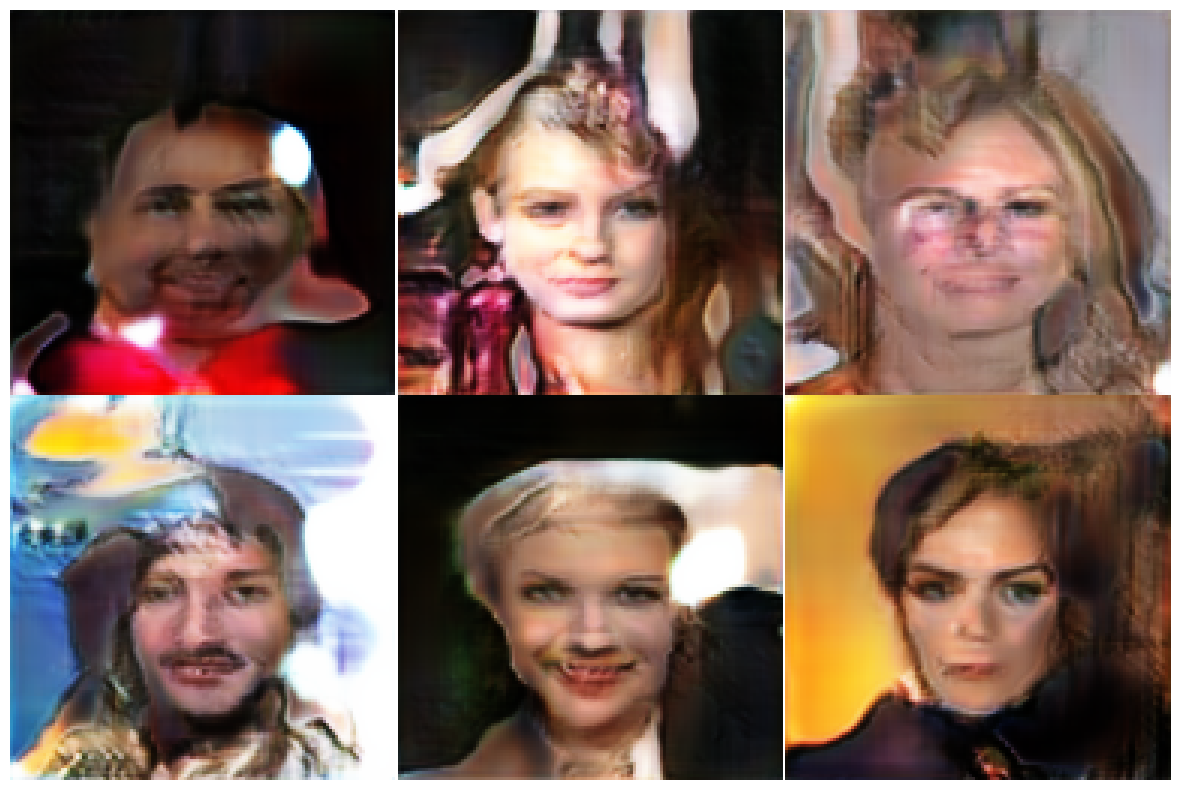

In [ ]:
y = G(z_test)
y = y.cpu().detach().numpy()
plot_samples(y)

In [ ]:
checkpoint0 = torch.load('output/generated/imgs_gan_celeba_2025-09-26-18-56.pt')
checkpoint1 = torch.load('output/generated/imgs_gan_celeba_2025-09-26-20-12.pt')
checkpoint2 = torch.load('output/generated/imgs_gan_celeba_2025-09-26-21-58.pt')
checkpoint3 = torch.load('output/generated/imgs_gan_celeba_2025-09-27-11-12.pt')
checkpoint4 = torch.load('output/generated/imgs_gan_celeba_2025-09-27-15-26.pt')

In [121]:
images = checkpoint0['images'] + checkpoint1['images'] + checkpoint2['images'] + checkpoint3['images']

In [91]:
len(images)

643

In [117]:
import matplotlib.animation as animation
from IPython.display import HTML

In [170]:
def make_grid(image):
    return np.hstack(image.transpose(0, 2, 3, 1))

def animate_images_inline(image_list, interval=100, save_path=None):
    """
    Animate a list of images inline in Jupyter.
    
    Args:
        image_list (list): list of numpy arrays (H, W) or (H, W, C).
        interval (int): delay between frames in ms.
    """
    h, w = make_grid(image_list[0]).shape[:2]
    fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
    img = ax.imshow(make_grid(image_list[0]), animated=True)
    ax.axis("off")

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    def update(frame):
        img.set_array(make_grid(image_list[frame]))
        return [img]

    ani = animation.FuncAnimation(
        fig, update, frames=len(image_list), interval=interval, blit=True
    )
    
    if save_path:
        if save_path.endswith(".gif"):
            ani.save(save_path, writer="imagemagick")
        else:  # e.g. .mp4
            ani.save(save_path, writer="ffmpeg")
    else:
        plt.show()

    return ani

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


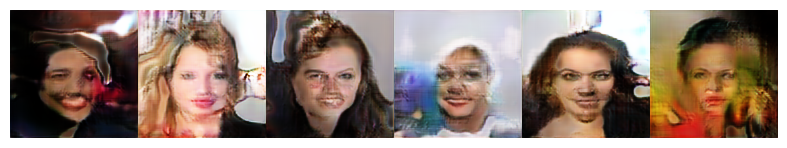

In [171]:
animate_images_inline(images[:100], interval=100, save_path="gan_animation.gif")